In [1]:
%load_ext autoreload
%autoreload 2

## imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import shap
from pylamp.loss.losses import RMSELoss
from pylamp.neural.activations import ReLU
from pylamp.neural.layers import Linear
from pylamp.neural.sequential import Sequential
from pylamp.optim.optimizer import SGD, Optim
from pylamp.utils.plotter import Display



## Loading data

You can find the dataset on [kaggle](https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset)

In [3]:
# Load the CSV file
file_path = './data/healthInsurance/insurance.csv'
data = pd.read_csv(file_path)

In [4]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Preprocessing data

In [5]:
# Turn 'sex' feature to numerical: 0 for female, 1 for male
data['sex'] = data['sex'].apply(lambda x: 1 if x == 'male' else 0)

# Turn 'smoker' feature to numerical: 0 for no, 1 for yes
data['smoker'] = data['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

# One-hot encode the 'region' feature
data = pd.get_dummies(data, columns=['region'], drop_first=True).astype(int)



# Separate features and target
X = data.drop('charges', axis=1)
feature_names = X.columns
X = X.values
y = data['charges'].values.reshape(-1, 1)

# # features scaling
scaler = MinMaxScaler() 
X = scaler.fit_transform(X)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')


X shape: (1338, 8)
y shape: (1338, 1)


## Train Test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building the model

In [7]:


input_size = X_train.shape[1]
output_size = y_train.shape[1]

# Create a sequential model
model = Sequential()

# Add modules to the sequential model
model.add_module(Linear(input_size=input_size, output_size=8))
model.add_module(ReLU())
model.add_module(Linear(input_size=8, output_size=16))
model.add_module(ReLU())
model.add_module(Linear(input_size=16, output_size=output_size))

loss_func = RMSELoss()
optimizer = Optim(model,loss_func,1e-2)
batch_size = 32
epochs = 1000
losses = SGD(optimizer,X_train, y_train, batch_size,epochs,verbose=True)

Epoch 1/1000, Average Loss: 17775.843900379776
Epoch 101/1000, Average Loss: 5921.663102651989
Epoch 201/1000, Average Loss: 5122.763415241596
Epoch 301/1000, Average Loss: 4836.419429418903
Epoch 401/1000, Average Loss: 4709.025461509721
Epoch 501/1000, Average Loss: 4805.298970163396
Epoch 601/1000, Average Loss: 4679.531672706367
Epoch 701/1000, Average Loss: 4624.940801544832
Epoch 801/1000, Average Loss: 4623.348089578085
Epoch 901/1000, Average Loss: 4549.915949416615
Training finished.


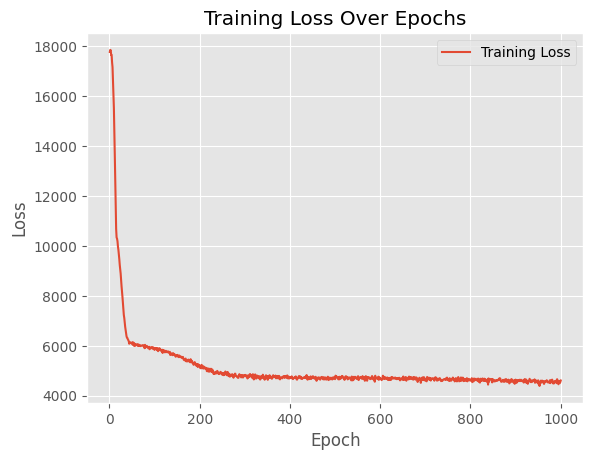

In [8]:
Display().plot_loss(losses)

In [9]:
# Evaluate the model on the test set
y_test_pred = model.forward(X_test)
rmse_test = RMSELoss().forward(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Test RMSE: {rmse_test}')
print(f'Test R^2: {r2_test}')


Test RMSE: 4367.489009157164
Test R^2: 0.87713265925774


In [10]:


# Initialize KernelExplainer with a sample of background data (use training data)
explainer = shap.KernelExplainer(model.forward,shap.sample(X_train, 100))

In [11]:

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test[5:6])

  0%|          | 0/1 [00:00<?, ?it/s]